## Setting up Undamped Unforced Duffing equation

In [11]:
from ptlpinns.perturbation import LPM
from ptlpinns.odes import equations, numerical
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [12]:
w_0 = 1
t_span = (0, 10)
N = 51200
t_eval = np.linspace(t_span[0], t_span[1], N)
ic = np.array([1, 0])
epsilon = 0.6

## Undamped

In [13]:
def forcing_zero(t):
    return np.zeros_like(t)

def ode_nl_duffing(t, y):
    return np.array([y[1], - (w_0 ** 2) * y[0] - epsilon * (y[0] ** 3) + forcing_zero(t)])

In [14]:
ode_0 = equations.ode_oscillator_1D(w_0=1, zeta=0, forcing_1D=lambda t: np.zeros_like(t), epsilon=0)
x_0 = numerical.solve_ode_equation(ode_0, (t_eval[0], t_eval[-1]), t_eval, [1,0])

In [15]:
x_lin = [x_0[0, :]]
ddot_x_lin = [np.gradient(x_0[1, :], t_eval)]
w_sol = [w_0]

In [16]:
n_corrections = 6

for p in range(1, n_corrections + 1):

    print(f"calculating term p: {p}")
    w_n = LPM.calc_w_n(w_list=w_sol, x=x_lin, x_ddot=ddot_x_lin, t=t_eval)
    print(f"omega {p}: {w_n}")

    x_n_forcing = LPM.calculate_forcing(w_n=w_n, w_list=w_sol, x=x_lin, x_ddot=ddot_x_lin)

    # defining forcing array as a function
    x_n_forcing_interp = CubicSpline(t_eval, x_n_forcing)

    # defining ode for x_n
    def ode_x_n(t, y):
        return np.array([y[1], - (w_0 ** 2) * y[0] + x_n_forcing_interp(t)])
    
    # solving x_n ode
    x_n_lin = (numerical.solve_ode_equation(ode_x_n, t_span, t_eval, np.array([0,0])))[0]   

    w_sol.append(w_n)
    x_lin.append(x_n_lin)
    ddot_x_lin.append(np.gradient(np.gradient(x_n_lin, t_eval), t_eval))

calculating term p: 1
omega 1: 0.37499782272901394
calculating term p: 2
omega 2: -0.08202717870979696
calculating term p: 3
omega 3: 0.03954705530545441
calculating term p: 4
omega 4: -0.024978998953525185
calculating term p: 5
omega 5: 0.017991156318788504
calculating term p: 6
omega 6: -0.013947130603102183


In [17]:
LPM.calculate_w_series(w_sol, epsilon, rwtol=1e-12)


[1,
 np.float64(1.2249986936374084),
 np.float64(1.1954689093018815),
 np.float64(1.2040110732478597),
 np.float64(1.200773794983483),
 np.float64(1.202172787298832),
 np.float64(1.2015220699734135)]

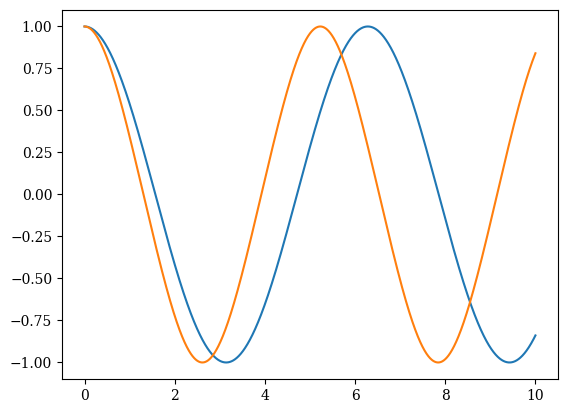

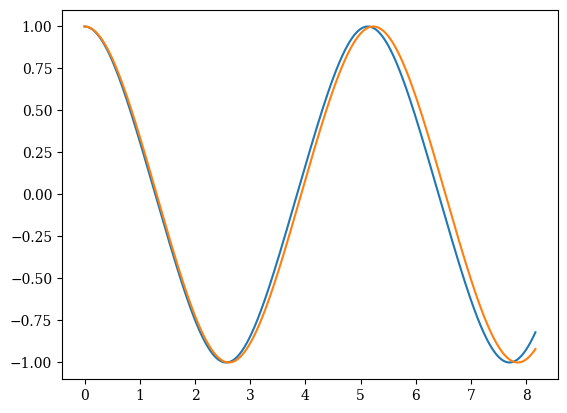

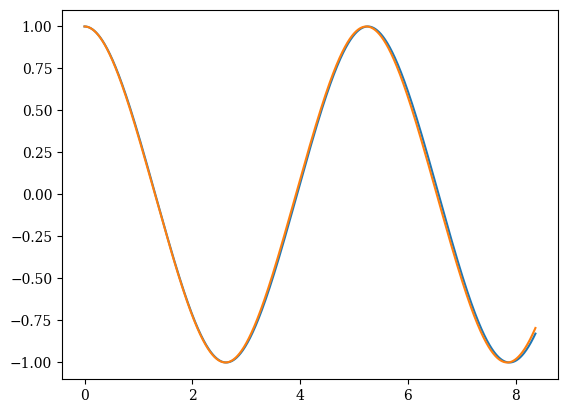

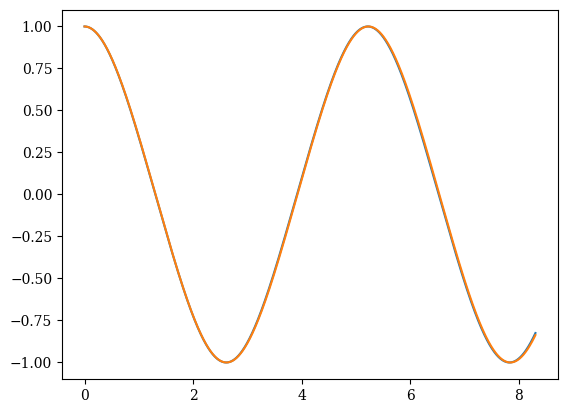

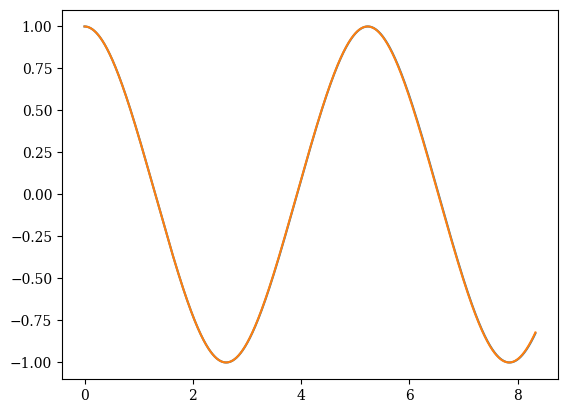

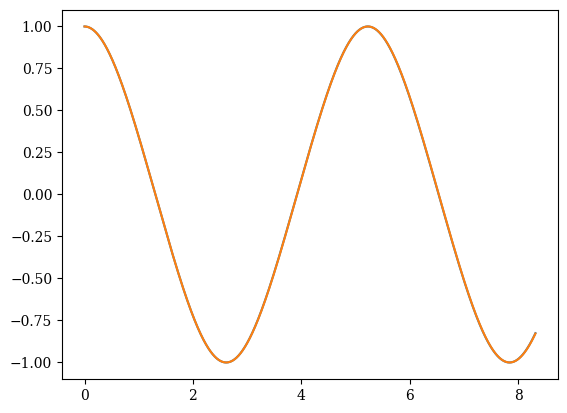

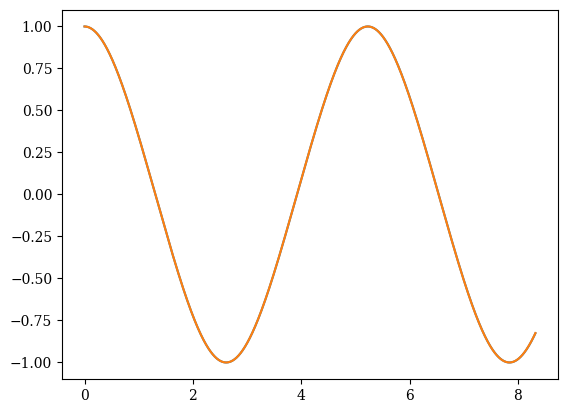

In [18]:
w_final = []
x_final = []
error_dash = []

for i in range(len(w_sol)):

    if i == 0:
        x_loop = numerical.solve_ode_equation(ode_0, (t_eval[0], t_eval[-1]), t_eval, [1,0])[0, :]
        w_loop = w_0
    else:
        w_loop = w_final[i - 1] + (epsilon ** i)  * w_sol[i]
        x_loop  = x_final[i - 1] + (epsilon ** i) * x_lin[i]

    w_final.append(w_loop)
    x_final.append(x_loop)

    t_span_loop = (0, t_span[-1]/w_loop)
    t_eval_loop = np.linspace(t_span_loop[0], t_span_loop[1], N)
    num_loop = numerical.solve_ode_equation(ode_nl_duffing, t_span_loop, t_eval_loop, ic)[0, :]

    error_dash.append(np.mean(np.abs(x_loop - num_loop)))

    plt.plot(t_eval_loop, x_loop)
    plt.plot(t_eval_loop, num_loop)
    plt.show()

In [19]:
error_dash

[np.float64(0.591447637242471),
 np.float64(0.05712742219173585),
 np.float64(0.015754862751925714),
 np.float64(0.005694700709167257),
 np.float64(0.0024034755696546077),
 np.float64(0.0011017363597167448),
 np.float64(0.0005276209532110372)]

### Underdamped